In [303]:
# Импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats

import statsmodels.api as sm

from mlxtend.feature_selection import SequentialFeatureSelector as sfs

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# Загрузка данных

In [304]:
data = pd.read_csv("input/data.csv", delimiter=";")
data.head()

,Год,y1,y2,y3,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11
0,1998,65120.0,328497.9,401044,120334,803.2,4767.0,1212184,33.8,10427.0,10759.00000,6171.0,6642.0,111458,1393.30
1,1999,93800.0,695059.8,577671,173332,787.6,4962.0,1272744,35.2,17310.0,17861.00000,7260.0,7814.0,185861,1807.80
2,2000,156215.0,1159034.0,962057,289037,1472.8,5277.0,1444737,32.4,24927.0,25720.20000,8067.0,9194.0,309534,2185.00
3,2001,173839.0,1370182.8,1257513,351188,1154.6,5712.2,1841258,30.4,33701.0,34773.39673,5545.0,12637.0,418289,2385.26
4,2002,220396.0,1767476.7,1544402,380535,1508.7,5832.4,2255912,35.1,46034.0,25688.00000,6932.0,13817.0,589139,2918.55


### Объяснение переменных
- $y_1$ - инвестиции в основной капитал, млн руб.
- $y_2$ - валовой региональный продукт (ВРП), млн.руб.
- $y_3$ - сумма доходов населения за год, млн руб.
- $x_1$ - финансовый результат деятельности (чистая прибыль)
- $x_2$ - прямые иностранные инвестиции, млн USD
- $x_3$ - среднегодовая численности занятых, тыс чел.
- $x_4$ - стоимость основных фондов, млн. руб
- $x_5$ - степень износа основных фондов, %
- $x_6$ - затраты на научные исследования и разработки, млн руб.
- $x_7$ - объём инновационных товаров работ услуг, млн руб.
- $x_8$ - экспорт, млн USD
- $x_9$ - импорт, млн. USD
- $x_{10}$ - сумма остатков вкладов на счетах в Банке России, млн. руб.
- $x_{11}$ - прожиточный минимум в регионе РФ (г. Москва), тыс.руб.

### Системы уравнений

#### Система независимых уравнений
$$
\begin{cases}
y_1 = \beta_{11}x_{1} + \beta_{21}x_{2} + \epsilon \\
y_2 = \beta_{21}x_{} + \beta_{22}x_{2} + \beta_{23}x_{3} + \beta_{24}x_{4} + \beta_{25}x_{5} + \beta_{26}x_{6} + \beta_{27}x_{7} + \beta_{28}x_{8} - \beta_{29}x_{9} + \epsilon \\
y_3 = \beta_{31}x_{1} + \beta_{32}x_{2} + \beta_{33}x_{3} + \beta_{34}x_{4} + \beta_{35}x_{5} + \beta_{36}x_{6} + \beta_{37}x_{7} + \beta_{38}x_{8} - \beta_{39}x_{9} + \beta_{310}x_{10} + \beta_{311}x_{11} + \epsilon \\
\end{cases}
$$

#### Система независимых уравнений
$$
\begin{cases}
y_1 = \beta_{11}x_{1} + \beta_{21}x_{2} + \epsilon \\
y_2 = \\
y_3 = \\
\end{cases}
$$

#### Система независимых уравнений
$$
\begin{cases}
y_1 = \beta_{11}x_{1} + \beta_{21}x_{2} + \epsilon \\
y_2 = \\
y_3 = \\
\end{cases}
$$

#### Альтернативная система
$$ВРП = Y_1 + Y_ 2+ Y_3 + Y_4 + Y_5$$

$$
\begin{cases}
Y_{\text{1-Внутренний сектор}} = Y_{\text{4-Факторы предложения}} + Y_{\text{2-Внешний сектор}} + Y_{\text{5-Экзогенные переменные}} + x{\dots}\\

Y_{\text{2-Внешний сектор}} = Y_{\text{5-Экзогенные переменные}} + x{\dots}\\

Y_{\text{3-Бюджетная система}} = Y_{\text{1-Внутренний сектор}} + Y_{\text{4-Факторы предложения}} + Y_{\text{5-Экзогенные переменные}} + x{\dots}\\

Y_{\text{4-Факторы предложения}} = Y_{\text{1-Внутренний сектор}} + Y_{\text{2-Внешний сектор}} + Y_{\text{3-Бюджетная система}} + x{\dots}\\

Y_{\text{5-Экзогенные переменные}} = x{\dots}\\
\end{cases}
$$

## Матрица коэффициентов межфакторной корреляции

<Axes: >

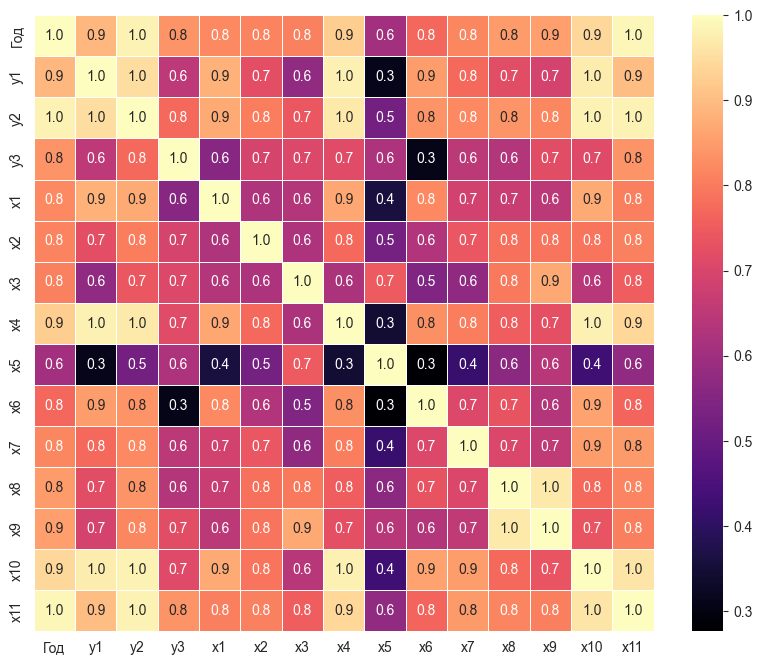

In [305]:
fig, ax = plt.subplots(figsize=(10, 8))

# data.corr()

# sns.heatmap(data.corr(), annot=True, fmt=".1f", linewidth=.5)
# sns.heatmap(data.corr(), annot=True, fmt=".1f", linewidth=.5, cmap='crest')
# sns.heatmap(data.corr(), annot=True, fmt=".1f", linewidth=.5, cmap='cubehelix')
# sns.heatmap(data.corr(), annot=True, fmt=".1f", linewidth=.5, cmap='vlag')
# sns.heatmap(data.corr(), annot=True, fmt=".1f", linewidth=.5, cmap='icefire')
sns.heatmap(data.corr(), annot=True, fmt=".1f", linewidth=.5, cmap='magma')

<Axes: >

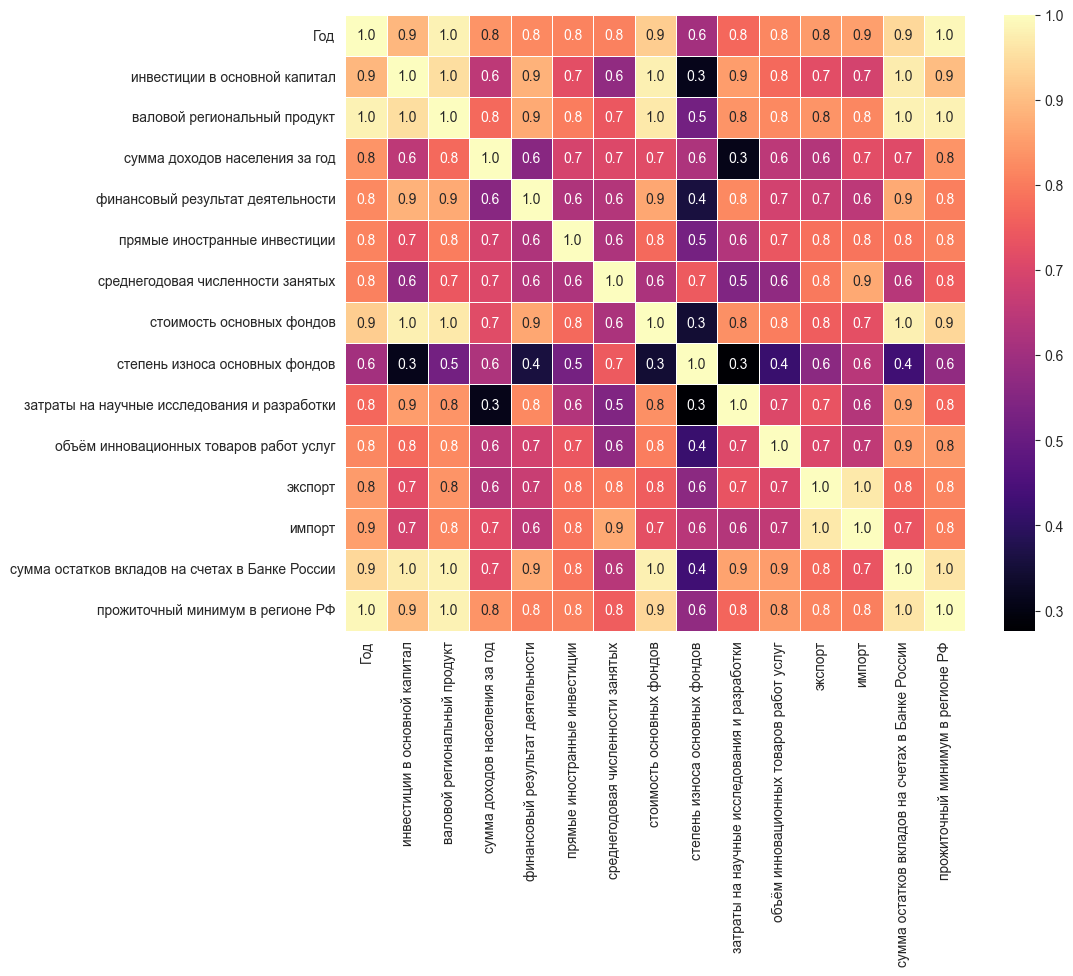

In [306]:
un_data = data.copy()
un_data.columns = ['Год', 'инвестиции в основной капитал', 'валовой региональный продукт', 'сумма доходов населения за год', 'финансовый результат деятельности', 'прямые иностранные инвестиции', 'среднегодовая численности занятых', 'стоимость основных фондов', 'степень износа основных фондов', 'затраты на научные исследования и разработки', 'объём инновационных товаров работ услуг', 'экспорт', 'импорт', 'сумма остатков вкладов на счетах в Банке России', 'прожиточный минимум в регионе РФ']

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(un_data.corr(), annot=True, fmt=".1f", linewidth=.5, cmap='magma')

# Избавляемся от выбросов

In [307]:
data.shape

(25, 15)

**Z-оценка**

In [308]:
z = np.abs(stats.zscore(data))
data_clean = data[(z < 3).all(axis=1)]
data_clean.shape

(24, 15)

**Межквартильный размах (IQR)**

In [309]:
#find Q1, Q3, and interquartile range for each column
Q1 = data.quantile(q=.25)
Q3 = data.quantile(q=.75)
IQR = data.apply(stats.iqr)

#only keep rows in dataframe that have values within 1.5\*IQR of Q1 and Q3
data_clean = data[~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)]
data_clean.shape  # без 20,21,22 годов

(22, 15)

In [310]:
data = data_clean

# Отбор переменных

In [311]:
data.head()

,Год,y1,y2,y3,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11
0,1998,65120.0,328497.9,401044,120334,803.2,4767.0,1212184,33.8,10427.0,10759.00000,6171.0,6642.0,111458,1393.30
1,1999,93800.0,695059.8,577671,173332,787.6,4962.0,1272744,35.2,17310.0,17861.00000,7260.0,7814.0,185861,1807.80
2,2000,156215.0,1159034.0,962057,289037,1472.8,5277.0,1444737,32.4,24927.0,25720.20000,8067.0,9194.0,309534,2185.00
3,2001,173839.0,1370182.8,1257513,351188,1154.6,5712.2,1841258,30.4,33701.0,34773.39673,5545.0,12637.0,418289,2385.26
4,2002,220396.0,1767476.7,1544402,380535,1508.7,5832.4,2255912,35.1,46034.0,25688.00000,6932.0,13817.0,589139,2918.55


In [312]:
y = data[['y1', 'y2', 'y3']]
y1 = y['y1']
y2 = y['y2']
y3 = y['y3']

In [313]:
X = data[['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11']]
x1 = X['x1']
x2 = X['x2']
x3 = X['x3']
x4 = X['x4']
x5 = X['x5']
x6 = X['x6']
x7 = X['x7']
x8 = X['x8']
x9 = X['x9']
x10 = X['x10']
x11 = X['x11']

In [314]:
class CustomLinearRegression():
    def __init__(self, y, x):
        self.y = y
        self.x = x
        # x = sm.add_constant(x)
        self.model = sm.OLS(y, x).fit()

    def summary(self):
        print(self.model.summary())

    def pre(self):
        return self.model.predict(self.x)

    def F(self):
        return self.model.fvalue

    def p(self):
        return self.model.f_pvalue

    def current_p(self, i):
        return self.model.pvalues[i]

    def R2(self):
        return self.model.rsquared

    def R2_adj(self):
        return self.model.rsquared_adj

    def t(self):
        return self.model.tvalues

    def forward_selection(self):
        xi = []
        stop = False
        x_new = []  # список переменных, которые будут включены в модель
        x_len = len(self.x.columns)  # количество столбцов в датафрейме
        x_test = []
        for n in range(x_len):
            F_max = 0  # максимальное значение F
            p_max = 0  # максимальное значение p
            F_max_i = 0
            F_max_x = ''
            if not stop:
                for i in range(x_len):
                    if i not in xi:
                        x_test = x_new.copy()
                        x_test.append(self.x.columns[i])
                        F = CustomLinearRegression(self.y, self.x.loc[:, x_test]).F()
                        print(f"'x{i + 1}',", F)
                        if F > F_max:
                            F_max = F
                            F_max_i = i
                            F_max_x = f"x{i + 1}"
                x_new.append(F_max_x)
                xi.append(F_max_i)
                print(x_new)
                for j in range(len(x_new)):
                    p = CustomLinearRegression(self.y, self.x.loc[:, x_new]).current_p(j)
                    if p > 0.05:
                        stop = True
                        print(f'P-value: {p}')
                        break
        CustomLinearRegression(self.y, self.x.loc[:, x_new[:-1]]).summary()

    def correlation_map(self):
        return sns.heatmap(self.x.corr(), annot=True, fmt=".1f", linewidth=.5, cmap='magma')

## Оценка ранее предложенный систем уравнений
## Система независимых уравнений (Вариант 1)
$$
\begin{cases}
y_1 = \beta_{11}x_{1} + \beta_{21}x_{2} + \epsilon \\
y_2 = \beta_{21}x_{} + \beta_{22}x_{2} + \beta_{23}x_{3} + \beta_{24}x_{4} + \beta_{25}x_{5} + \beta_{26}x_{6} + \beta_{27}x_{7} + \beta_{28}x_{8} - \beta_{29}x_{9} + \epsilon \\
y_3 = \beta_{31}x_{1} + \beta_{32}x_{2} + \beta_{33}x_{3} + \beta_{34}x_{4} + \beta_{35}x_{5} + \beta_{36}x_{6} + \beta_{37}x_{7} + \beta_{38}x_{8} - \beta_{39}x_{9} + \beta_{310}x_{10} + \beta_{311}x_{11} + \epsilon \\
\end{cases}
$$

### Первое уравнение
$$y_1 = \beta_{11}x_{1} + \beta_{21}x_{2} + \epsilon$$

#### Исходное уравнение

In [315]:
fn1 = pd.concat([x1, x2], axis=1)
CustomLinearRegression(y1, fn1).summary()

                                 OLS Regression Results                                
Dep. Variable:                     y1   R-squared (uncentered):                   0.891
Model:                            OLS   Adj. R-squared (uncentered):              0.880
Method:                 Least Squares   F-statistic:                              81.56
Date:                Thu, 06 Apr 2023   Prob (F-statistic):                    2.42e-10
Time:                        07:58:41   Log-Likelihood:                         -316.31
No. Observations:                  22   AIC:                                      636.6
Df Residuals:                      20   BIC:                                      638.8
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### Второе уравнение
$$y_2 = \beta_{21}x_{} + \beta_{22}x_{2} + \beta_{23}x_{3} + \beta_{24}x_{4} + \beta_{25}x_{5} + \beta_{26}x_{6} + \beta_{27}x_{7} + \beta_{28}x_{8} - \beta_{29}x_{9} + \epsilon$$

#### Исходное уравнение

In [316]:
fn2 = pd.concat([x1, x2, x3, x4, x5, x6, x7, x8, -x9], axis=1)
CustomLinearRegression(y2, fn2).summary()

                                 OLS Regression Results                                
Dep. Variable:                     y2   R-squared (uncentered):                   0.996
Model:                            OLS   Adj. R-squared (uncentered):              0.993
Method:                 Least Squares   F-statistic:                              338.6
Date:                Thu, 06 Apr 2023   Prob (F-statistic):                    6.30e-14
Time:                        07:58:41   Log-Likelihood:                         -325.95
No. Observations:                  22   AIC:                                      669.9
Df Residuals:                      13   BIC:                                      679.7
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

#### Исходное уравнение с исключением статистически незначимых параметров

In [317]:
# Методом прямого включения
CustomLinearRegression(y2, fn2).forward_selection()

'x1', 150.60908846649005
'x2', 58.65853830896886
'x3', 137.25811226149457
'x4', 372.23803322041283
'x5', 56.26761638636537
'x6', 2731.1043331428664
'x7', 51.335867748105784
'x8', 147.20995532161095
'x9', 152.41635247932524
['x6']
'x1', 1523.5906379865194
'x2', 1300.5458599719486
'x3', 1347.7445889092326
'x4', 1834.3853810677128
'x5', 1362.2966815395264
'x7', 1409.3998021766663
'x8', 1326.103650380541
'x9', 1339.4468806115665
['x6', 'x4']
'x1', 1290.969739137984
'x2', 1163.1980661500536
'x3', 1192.483569269291
'x5', 1170.4531346090398
'x7', 1361.4248715724568
'x8', 1161.7775972725212
'x9', 1170.0610820497552
['x6', 'x4', 'x7']
P-value: 0.08742668306995051
                                 OLS Regression Results                                
Dep. Variable:                     y2   R-squared (uncentered):                   0.995
Model:                            OLS   Adj. R-squared (uncentered):              0.994
Method:                 Least Squares   F-statistic:                     

In [318]:
# Методом обратного исключения
CustomLinearRegression(y2, fn2).summary()
CustomLinearRegression(y2, fn2.drop(columns=['x9'])).summary()
CustomLinearRegression(y2, fn2.drop(columns=['x9', 'x2'])).summary()
CustomLinearRegression(y2, fn2.drop(columns=['x9', 'x2', 'x5'])).summary()
CustomLinearRegression(y2, fn2.drop(columns=['x9', 'x2', 'x5', 'x8'])).summary()
CustomLinearRegression(y2, fn2.drop(columns=['x9', 'x2', 'x5', 'x8', 'x3'])).summary()
CustomLinearRegression(y2, fn2.drop(columns=['x9', 'x2', 'x5', 'x8', 'x3', 'x1'])).summary()
CustomLinearRegression(y2, fn2.drop(columns=['x9', 'x2', 'x5', 'x8', 'x3', 'x1', 'x7'])).summary()

                                 OLS Regression Results                                
Dep. Variable:                     y2   R-squared (uncentered):                   0.996
Model:                            OLS   Adj. R-squared (uncentered):              0.993
Method:                 Least Squares   F-statistic:                              338.6
Date:                Thu, 06 Apr 2023   Prob (F-statistic):                    6.30e-14
Time:                        07:58:41   Log-Likelihood:                         -325.95
No. Observations:                  22   AIC:                                      669.9
Df Residuals:                      13   BIC:                                      679.7
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### Третье уравнение
$$y_3 = \beta_{31}x_{1} + \beta_{32}x_{2} + \beta_{33}x_{3} + \beta_{34}x_{4} + \beta_{35}x_{5} + \beta_{36}x_{6} + \beta_{37}x_{7} + \beta_{38}x_{8} - \beta_{39}x_{9} + \beta_{310}x_{10} + \beta_{311}x_{11} + \epsilon$$

#### Исходное уравнение

In [319]:
fn3 = pd.concat([x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11], axis=1)
CustomLinearRegression(y3, fn3).summary()

                                 OLS Regression Results                                
Dep. Variable:                     y3   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                              817.6
Date:                Thu, 06 Apr 2023   Prob (F-statistic):                    2.28e-14
Time:                        07:58:42   Log-Likelihood:                         -301.81
No. Observations:                  22   AIC:                                      625.6
Df Residuals:                      11   BIC:                                      637.6
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

#### Исходное уравнение с исключением статистически незначимых параметров

In [320]:
# Методом прямого включения
CustomLinearRegression(y3, fn3).forward_selection()

'x1', 159.9973226407594
'x2', 58.57969729834865
'x3', 182.28418048262196
'x4', 248.1090009771349
'x5', 74.79103935414454
'x6', 5212.10696147342
'x7', 53.065769386314095
'x8', 157.27533841509265
'x9', 186.23780558680446
'x10', 351.68497780330824
'x11', 3949.5284394999353
['x6']
'x1', 3867.9551936066323
'x2', 2487.680172503642
'x3', 2929.435470103968
'x4', 2518.4604719235645
'x5', 3980.733636631952
'x7', 2740.008287938285
'x8', 2503.934908664474
'x9', 2577.743206801062
'x10', 2981.539948018116
'x11', 3147.223861629187
['x6', 'x5']
'x1', 4216.383484358749
'x2', 2535.2669824936524
'x3', 2560.04616000949
'x4', 2741.3589487109175
'x7', 2613.314201733371
'x8', 2570.7008752563975
'x9', 2528.0143218172475
'x10', 2531.421243216547
'x11', 2584.723317601827
['x6', 'x5', 'x1']
'x2', 3094.7570515227426
'x3', 2996.8982821409995
'x4', 3009.3593482825404
'x7', 3019.221680908373
'x8', 3034.590040657796
'x9', 3016.6513489806803
'x10', 2998.6628306194293
'x11', 3044.408264028228
['x6', 'x5', 'x1', 'x2']
P

In [321]:
# Методом обратного исключения
CustomLinearRegression(y3, fn3).summary()
CustomLinearRegression(y3, fn3.drop(columns=['x8'])).summary()
CustomLinearRegression(y3, fn3.drop(columns=['x8', 'x5'])).summary()
CustomLinearRegression(y3, fn3.drop(columns=['x8', 'x5', 'x3'])).summary()
CustomLinearRegression(y3, fn3.drop(columns=['x8', 'x5', 'x3', 'x4'])).summary()
CustomLinearRegression(y3, fn3.drop(columns=['x8', 'x5', 'x3', 'x4', 'x9'])).summary()
CustomLinearRegression(y3, fn3.drop(columns=['x8', 'x5', 'x3', 'x4', 'x9', 'x7'])).summary()
CustomLinearRegression(y3, fn3.drop(columns=['x8', 'x5', 'x3', 'x4', 'x9', 'x7', 'x2'])).summary()

                                 OLS Regression Results                                
Dep. Variable:                     y3   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                              817.6
Date:                Thu, 06 Apr 2023   Prob (F-statistic):                    2.28e-14
Time:                        07:58:42   Log-Likelihood:                         -301.81
No. Observations:                  22   AIC:                                      625.6
Df Residuals:                      11   BIC:                                      637.6
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## Система независимых уравнений (Вариант 2)

### Первое уравнение

In [322]:
# Методом прямого включения
CustomLinearRegression(y1, X).forward_selection()

'x1', 131.50484812573313
'x2', 45.289661506719185
'x3', 73.15293853442348
'x4', 1112.0431265735392
'x5', 39.55494311044488
'x6', 390.19361040514093
'x7', 44.46217071579106
'x8', 86.70576309663797
'x9', 83.43475550095445
'x10', 469.82721850544766
'x11', 368.1556861132621
['x4']
'x1', 614.1118432426871
'x2', 531.3816433481165
'x3', 680.1370080606215
'x5', 765.4695424926385
'x6', 734.638690146448
'x7', 533.8044983374193
'x8', 583.0775953933153
'x9', 641.1393870140723
'x10', 583.9859338985378
'x11', 802.1256009881924
['x4', 'x11']
'x1', 519.7243619881918
'x2', 554.8938626141738
'x3', 508.77656575171164
'x5', 521.4098647323154
'x6', 520.9725758977364
'x7', 593.7813939108255
'x8', 510.00551364089614
'x9', 508.20186344159157
'x10', 515.1606956848201
['x4', 'x11', 'x7']
P-value: 0.09108016035365607
                                 OLS Regression Results                                
Dep. Variable:                     y1   R-squared (uncentered):                   0.988
Model:                

In [323]:
# Методом обратного исключения
CustomLinearRegression(y1, X).summary()
CustomLinearRegression(y1, X.drop(columns=['x11'])).summary()
CustomLinearRegression(y1, X.drop(columns=['x11', 'x8'])).summary()
CustomLinearRegression(y1, X.drop(columns=['x11', 'x8', 'x3'])).summary()
CustomLinearRegression(y1, X.drop(columns=['x11', 'x8', 'x3', 'x1'])).summary()
CustomLinearRegression(y1, X.drop(columns=['x11', 'x8', 'x3', 'x1', 'x6'])).summary()
CustomLinearRegression(y1, X.drop(columns=['x11', 'x8', 'x3', 'x1', 'x6', 'x9'])).summary()
CustomLinearRegression(y1, X.drop(columns=['x11', 'x8', 'x3', 'x1', 'x6', 'x9', 'x2'])).summary()
CustomLinearRegression(y1, X.drop(columns=['x11', 'x8', 'x3', 'x1', 'x6', 'x9', 'x2', 'x7'])).summary()
CustomLinearRegression(y1, X.drop(columns=['x11', 'x8', 'x3', 'x1', 'x6', 'x9', 'x2', 'x7', 'x10'])).summary()

                                 OLS Regression Results                                
Dep. Variable:                     y1   R-squared (uncentered):                   0.992
Model:                            OLS   Adj. R-squared (uncentered):              0.984
Method:                 Least Squares   F-statistic:                              126.7
Date:                Thu, 06 Apr 2023   Prob (F-statistic):                    6.09e-10
Time:                        07:58:42   Log-Likelihood:                         -287.32
No. Observations:                  22   AIC:                                      596.6
Df Residuals:                      11   BIC:                                      608.6
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### Второе уравнение

In [324]:
# Методом прямого включения
CustomLinearRegression(y2, X).forward_selection()

'x1', 150.60908846649005
'x2', 58.65853830896886
'x3', 137.25811226149457
'x4', 372.23803322041283
'x5', 56.26761638636537
'x6', 2731.1043331428664
'x7', 51.335867748105784
'x8', 147.20995532161095
'x9', 152.41635247932524
'x10', 577.4388111879503
'x11', 1944.7872650513564
['x6']
'x1', 1523.5906379865194
'x2', 1300.5458599719486
'x3', 1347.7445889092326
'x4', 1834.3853810677128
'x5', 1362.2966815395264
'x7', 1409.3998021766663
'x8', 1326.103650380541
'x9', 1339.4468806115665
'x10', 1564.2859559049102
'x11', 1352.928568905816
['x6', 'x4']
'x1', 1290.969739137984
'x2', 1163.1980661500536
'x3', 1192.483569269291
'x5', 1170.4531346090398
'x7', 1361.4248715724568
'x8', 1161.7775972725212
'x9', 1170.0610820497552
'x10', 1171.7229888579182
'x11', 1278.8559885591287
['x6', 'x4', 'x7']
P-value: 0.08742668306995051
                                 OLS Regression Results                                
Dep. Variable:                     y2   R-squared (uncentered):                   0.995
Model: 

In [325]:
# Методом обратного исключения
CustomLinearRegression(y2, X).summary()
CustomLinearRegression(y2, X.drop(columns=['x3'])).summary()
CustomLinearRegression(y2, X.drop(columns=['x3', 'x8'])).summary()
CustomLinearRegression(y2, X.drop(columns=['x3', 'x8', 'x2'])).summary()
CustomLinearRegression(y2, X.drop(columns=['x3', 'x8', 'x2', 'x10'])).summary()
CustomLinearRegression(y2, X.drop(columns=['x3', 'x8', 'x2', 'x10', 'x6'])).summary()
CustomLinearRegression(y2, X.drop(columns=['x3', 'x8', 'x2', 'x10', 'x6', 'x1'])).summary()

                                 OLS Regression Results                                
Dep. Variable:                     y2   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.997
Method:                 Least Squares   F-statistic:                              779.5
Date:                Thu, 06 Apr 2023   Prob (F-statistic):                    2.96e-14
Time:                        07:58:42   Log-Likelihood:                         -312.77
No. Observations:                  22   AIC:                                      647.5
Df Residuals:                      11   BIC:                                      659.5
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### Третье уравнение

In [326]:
# Методом прямого включения
CustomLinearRegression(y3, X).forward_selection()

'x1', 159.9973226407594
'x2', 58.57969729834865
'x3', 182.28418048262196
'x4', 248.1090009771349
'x5', 74.79103935414454
'x6', 5212.10696147342
'x7', 53.065769386314095
'x8', 157.27533841509265
'x9', 186.23780558680446
'x10', 351.68497780330824
'x11', 3949.5284394999353
['x6']
'x1', 3867.9551936066323
'x2', 2487.680172503642
'x3', 2929.435470103968
'x4', 2518.4604719235645
'x5', 3980.733636631952
'x7', 2740.008287938285
'x8', 2503.934908664474
'x9', 2577.743206801062
'x10', 2981.539948018116
'x11', 3147.223861629187
['x6', 'x5']
'x1', 4216.383484358749
'x2', 2535.2669824936524
'x3', 2560.04616000949
'x4', 2741.3589487109175
'x7', 2613.314201733371
'x8', 2570.7008752563975
'x9', 2528.0143218172475
'x10', 2531.421243216547
'x11', 2584.723317601827
['x6', 'x5', 'x1']
'x2', 3094.7570515227426
'x3', 2996.8982821409995
'x4', 3009.3593482825404
'x7', 3019.221680908373
'x8', 3034.590040657796
'x9', 3016.6513489806803
'x10', 2998.6628306194293
'x11', 3044.408264028228
['x6', 'x5', 'x1', 'x2']
P

In [327]:
# Методом обратного исключения
CustomLinearRegression(y3, X).summary()
CustomLinearRegression(y3, X.drop(columns=['x8'])).summary()
CustomLinearRegression(y3, X.drop(columns=['x8', 'x5'])).summary()
CustomLinearRegression(y3, X.drop(columns=['x8', 'x5', 'x3'])).summary()
CustomLinearRegression(y3, X.drop(columns=['x8', 'x5', 'x3', 'x4'])).summary()
CustomLinearRegression(y3, X.drop(columns=['x8', 'x5', 'x3', 'x4', 'x9'])).summary()
CustomLinearRegression(y3, X.drop(columns=['x8', 'x5', 'x3', 'x4', 'x9', 'x7'])).summary()
CustomLinearRegression(y3, X.drop(columns=['x8', 'x5', 'x3', 'x4', 'x9', 'x7', 'x2'])).summary()

                                 OLS Regression Results                                
Dep. Variable:                     y3   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                              817.6
Date:                Thu, 06 Apr 2023   Prob (F-statistic):                    2.28e-14
Time:                        07:58:42   Log-Likelihood:                         -301.81
No. Observations:                  22   AIC:                                      625.6
Df Residuals:                      11   BIC:                                      637.6
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------